In [1]:
import jwst
from astropy.table import Table
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import match_coordinates_sky,SkyCoord, Angle
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import warnings

warnings.filterwarnings('ignore')

band = "clear-f444w"
# path = "../../JWST/MAST_M16_Nov142022/JWST/jw02739-o001_t001_nircam_" # M16 - Pillars of Creation
path = "../../ngc3324/NIRCAM_ALL_cat/JWST/jw02731-o001_t017_nircam_" # NGC 3324 - Cosmic Cliffs

In [2]:
# band = 'f770w'
# t = Table.read(path+band+"/jw02739-o001_t001_nircam_"+band+"_cat.ecsv") # M16 - Pillars of Creation
t = Table.read(path+band+"/jw02731-o001_t017_nircam_"+band+"_cat.ecsv") # NGC 3324 - Cosmic Cliffs

t.info()

<Table length=3888>
         name           dtype    unit  format                                                                  description                                                                    class   n_bad
---------------------- ------- ------- ------ ---------------------------------------------------------------------------------------------------------------------------------------------- -------- -----
                 label   int64                                                                                                                     Unique source identification label number   Column     0
             xcentroid float64            .4f                                                                                                           X pixel value of the source centroid   Column     0
             ycentroid float64            .4f                                                                                                           Y pixel valu

In [3]:
t[132][['isophotal_vegamag','isophotal_vegamag_err']]

isophotal_vegamag,isophotal_vegamag_err
float64,float64
16.868959,0.001477


To brute force make a catalogue:

1) Start with the filter that has the most sources
2) Take the brightest source, grab it's RA/DEC, relate the size of it's 1-sigma psf size to deg and use this as tolerance.
3) Find all other objects in all other filters that are located within this tolerance
4) Take those filter mags/fluxes and plop into new dataframe
5) If one source has multiple objects associated with it in other filters, add them all into the rows and add a flag

In [4]:

path_m = "../../ngc3324/MIRI_ALL_cat/JWST/jw02731-o002_t017_miri_"
t = []

for i, band in enumerate(['clear-f090w', 'clear-f187n', 'clear-f200w', 'clear-f335m', 'clear-f444w', 'f444w-f470n']):
    # Get the tables
    # t.append(Table.read(path+band+"/jw02739-o001_t001_nircam_"+band+"_cat.ecsv")) # M16 - Pillars of Creation
    t.append(Table.read(path+band+"/jw02731-o001_t017_nircam_"+band+"_cat.ecsv")) # NGC 3324 - Cosmic Cliffs
    print(len(t[i]))


for i, band in enumerate(['f770w', 'f1130w', 'f1280w', 'f1800w']):
    # Get the tables
    t.append(Table.read(path_m+band+"/jw02731-o002_t017_miri_"+band+"_cat.ecsv"))
    print(len(t[i+6]))



7788
8968
19077
2507
3888
3300
230
185
157
167


In [5]:
meas_type = 'vegamag'
meas_type2 = 'flux'
ap_type = 'isophotal'
ap_type2 = 'aper30'
ap_type3 = 'aper50'
ap_type4 = 'aper70'
ap_type5 = 'aper_total'

for i, f in enumerate(['f090w', 'f187n', 'f200w', 'f335m', 'f444w', 'f444w-f470n','f770w', 'f1130w', 'f1280w', 'f1800w']):
    print(f)
    if i < 3:
        t[i]['size'] = np.sqrt((t[i]['semimajor_sigma']**2)+t[i]['semiminor_sigma']**2)*0.031/3600 # Convert pixels to arcseconds, arcseconds to degrees (F090,187,200)
    elif i<6:
        print(f)
        t[i]['size'] = np.sqrt((t[i]['semimajor_sigma']**2)+t[i]['semiminor_sigma']**2)*0.063/3600 # Convert pixels to arcseconds, arcseconds to degrees (F335,444,470) 
    else:
        t[i]['size'] = np.sqrt((t[i]['semimajor_sigma']**2)+t[i]['semiminor_sigma']**2)*0.11/3600 # Convert pixels to arcseconds, arcseconds to degrees (MIRI)
    
    t[i] = t[i].to_pandas()[['sky_centroid.ra', 'sky_centroid.dec','size', ap_type+'_'+meas_type, ap_type+'_'+meas_type+'_err', \
        ap_type2+'_'+meas_type, ap_type2+'_'+meas_type+'_err', ap_type3+'_'+meas_type, ap_type3+'_'+meas_type+'_err',\
            ap_type4+'_'+meas_type, ap_type4+'_'+meas_type+'_err',ap_type5+'_'+meas_type, ap_type5+'_'+meas_type+'_err',\
                ap_type+'_'+meas_type2, ap_type+'_'+meas_type2+'_err', \
        ap_type2+'_'+meas_type2, ap_type2+'_'+meas_type2+'_err', ap_type3+'_'+meas_type2, ap_type3+'_'+meas_type2+'_err',\
            ap_type4+'_'+meas_type2, ap_type4+'_'+meas_type2+'_err',ap_type5+'_'+meas_type2, ap_type5+'_'+meas_type2+'_err']]
    t[i].rename(columns={'sky_centroid.ra': 'RA', 'sky_centroid.dec': 'DEC',ap_type+'_'+meas_type:ap_type+'_'+meas_type+'_'+f, ap_type+'_'+meas_type+'_err': ap_type+'_'+meas_type+'_err_'+f,\
        ap_type2+'_'+meas_type:ap_type2+'_'+meas_type+'_'+f, ap_type2+'_'+meas_type+'_err': ap_type2+'_'+meas_type+'_err_'+f,ap_type3+'_'+meas_type:ap_type3+'_'+meas_type+'_'+f, ap_type3+'_'+meas_type+'_err': ap_type3+'_'+meas_type+'_err_'+f,\
            ap_type4+'_'+meas_type:ap_type4+'_'+meas_type+'_'+f, ap_type4+'_'+meas_type+'_err': ap_type4+'_'+meas_type+'_err_'+f,ap_type5+'_'+meas_type:ap_type5+'_'+meas_type+'_'+f, ap_type5+'_'+meas_type+'_err': ap_type5+'_'+meas_type+'_err_'+f,\
                ap_type+'_'+meas_type2:ap_type+'_'+meas_type2+'_'+f, ap_type+'_'+meas_type2+'_err': ap_type+'_'+meas_type2+'_err_'+f,\
        ap_type2+'_'+meas_type2:ap_type2+'_'+meas_type2+'_'+f, ap_type2+'_'+meas_type2+'_err': ap_type2+'_'+meas_type2+'_err_'+f,ap_type3+'_'+meas_type2:ap_type3+'_'+meas_type2+'_'+f, ap_type3+'_'+meas_type2+'_err': ap_type3+'_'+meas_type2+'_err_'+f,\
            ap_type4+'_'+meas_type2:ap_type4+'_'+meas_type2+'_'+f, ap_type4+'_'+meas_type2+'_err': ap_type4+'_'+meas_type2+'_err_'+f,ap_type5+'_'+meas_type2:ap_type5+'_'+meas_type2+'_'+f, ap_type5+'_'+meas_type2+'_err': ap_type5+'_'+meas_type2+'_err_'+f},inplace=True)

data_all_filters_NIRCam_MIRI = pd.concat([t[0],t[1],t[2],t[3],t[4],t[5],t[6],t[7],t[8],t[9]],ignore_index=True) # MIRI: ,t[6],t[7],t[8],t[9]
data_all_filters_NIRCam_MIRI.sort_values(ap_type+'_'+meas_type+'_f444w-f470n', ascending=True,inplace=True)
data_all_filters_NIRCam_MIRI.reset_index(drop=True,inplace=True)

f090w
f187n
f200w
f335m
f335m
f444w
f444w
f444w-f470n
f444w-f470n
f770w
f1130w
f1280w
f1800w


(array([2.0171e+04, 1.8272e+04, 4.0680e+03, 1.1840e+03, 6.7600e+02,
        4.2800e+02, 2.8600e+02, 1.7900e+02, 1.3900e+02, 1.0800e+02,
        8.4000e+01, 6.8000e+01, 5.0000e+01, 4.5000e+01, 4.0000e+01,
        3.5000e+01, 3.1000e+01, 2.7000e+01, 2.2000e+01, 2.5000e+01,
        1.6000e+01, 1.3000e+01, 1.4000e+01, 1.0000e+01, 1.1000e+01,
        2.0000e+01, 1.5000e+01, 1.2000e+01, 5.0000e+00, 9.0000e+00,
        5.0000e+00, 8.0000e+00, 3.0000e+00, 4.0000e+00, 9.0000e+00,
        7.0000e+00, 8.0000e+00, 5.0000e+00, 2.0000e+00, 5.0000e+00,
        4.0000e+00, 2.0000e+00, 5.0000e+00, 1.0000e+00, 2.0000e+00,
        1.0000e+00, 0.0000e+00, 3.0000e+00, 1.0000e+00, 5.0000e+00,
        3.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00, 3.0000e+00,
        3.0000e+00, 0.0000e+00, 4.0000e+00, 1.0000e+00, 1.0000e+00,
        2.0000e+00, 3.0000e+00, 3.0000e+00, 1.0000e+00, 3.0000e+00,
        0.0000e+00, 1.0000e+00, 3.0000e+00, 3.0000e+00, 1.0000e+00,
        1.0000e+00, 0.0000e+00, 2.0000e+00, 2.00

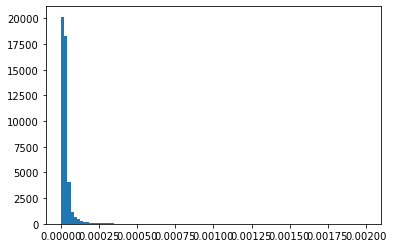

In [6]:
plt.hist(data_all_filters_NIRCam_MIRI['size'],bins=np.linspace(0,0.002,100))

In [7]:
# Use match coordinates sky
# Any object that isn't in index gets appended to the end of the dataframe, this makes the new catalog
# Use new catalog to match next set of objects

# ADD SPICY PREDS
filters = ['f090w', 'f187n','f335m','f444w','f444w-f470n','f770w','f1130w','f1280w','f1800w']

j_sky = SkyCoord(data_all_filters_NIRCam_MIRI.dropna(subset='isophotal_vegamag_f200w').RA*u.deg, data_all_filters_NIRCam_MIRI.dropna(subset='isophotal_vegamag_f200w').DEC*u.deg)
j_all = data_all_filters_NIRCam_MIRI.dropna(subset='isophotal_vegamag_f200w')
j_all = j_all[j_all.columns[~j_all.isnull().all()]]
j_all.reset_index(drop=True,inplace=True)
tol = max(data_all_filters_NIRCam_MIRI['size'])
for f in filters:
    # print(f)
    f_df = data_all_filters_NIRCam_MIRI.dropna(subset='isophotal_vegamag_'+f)
    f_df = f_df[f_df.columns[~f_df.isnull().all()]]
    print("# objects in",f,"filter:",len(f_df))
    add_sky = SkyCoord(f_df.RA*u.deg, f_df.DEC*u.deg)
    idx, sep2d, _ = match_coordinates_sky(add_sky,j_sky)
    sep_constraint = sep2d < tol*u.deg

    j_matches = j_all.iloc[idx[sep_constraint]] # All closest objects within sigma distance from catalog
    j_nonmatches = j_all.drop(idx[sep_constraint],axis=0) # All other objects from catalog
    j_matches.reset_index(drop=True,inplace=True)
    j_nonmatches.reset_index(drop=True,inplace=True)

    f_matches = f_df.iloc[sep_constraint] # All closest objects from filter
    f_nonmatches = f_df.iloc[~sep_constraint] # All other objects from filter
    f_matches.reset_index(drop=True,inplace=True)
    f_nonmatches.reset_index(drop=True,inplace=True)

    j_matches.RA = (j_matches.RA + f_matches.RA)/2
    j_matches.DEC = (j_matches.DEC + f_matches.DEC)/2

    j_nonmatches[f_matches.columns[3:]] = np.nan
    f_nonmatches[j_matches.columns[3:]] = np.nan

    j_all = pd.concat([j_matches,f_matches[f_matches.columns[3:]]],axis=1)
    print('# objects matched from',f,"filter:",len(j_all))
    j_all = pd.concat([j_all,j_nonmatches,f_nonmatches],axis=0)
    j_all.reset_index(drop=True,inplace=True)
    j_sky = SkyCoord(j_all.RA*u.deg,j_all.DEC*u.deg)


j_all
        

# objects in f090w filter: 7788
# objects matched from f090w filter: 7788
# objects in f187n filter: 8968
# objects matched from f187n filter: 8968
# objects in f335m filter: 2507
# objects matched from f335m filter: 2507
# objects in f444w filter: 3888
# objects matched from f444w filter: 3888
# objects in f444w-f470n filter: 3300
# objects matched from f444w-f470n filter: 3300
# objects in f770w filter: 230
# objects matched from f770w filter: 230
# objects in f1130w filter: 185
# objects matched from f1130w filter: 185
# objects in f1280w filter: 157
# objects matched from f1280w filter: 157
# objects in f1800w filter: 167
# objects matched from f1800w filter: 167


,RA,DEC,size,isophotal_vegamag_f200w,isophotal_vegamag_err_f200w,aper30_vegamag_f200w,aper30_vegamag_err_f200w,aper50_vegamag_f200w,aper50_vegamag_err_f200w,aper70_vegamag_f200w,...,isophotal_flux_f1800w,isophotal_flux_err_f1800w,aper30_flux_f1800w,aper30_flux_err_f1800w,aper50_flux_f1800w,aper50_flux_err_f1800w,aper70_flux_f1800w,aper70_flux_err_f1800w,aper_total_flux_f1800w,aper_total_flux_err_f1800w
0,159.201440,-58.599839,0.000015,21.722390,0.006693,22.863498,0.008853,22.209053,0.006832,21.653498,...,0.007871,1.192287e-06,0.000239,1.544436e-07,0.000491,2.325075e-07,0.001738,5.844820e-07,0.002574,8.657417e-07
1,159.200683,-58.601267,0.000021,19.709471,0.002130,21.059082,0.003399,20.471541,0.002594,19.898613,...,0.004000,3.800246e-07,0.000102,1.111296e-07,0.000219,1.578328e-07,0.000915,3.366074e-07,0.001356,4.985868e-07
2,159.209330,-58.593110,0.000027,19.548159,0.001977,21.348298,0.003598,20.622128,0.002589,19.852735,...,0.131089,4.882767e-06,0.000211,1.079168e-07,0.000439,1.598301e-07,0.001637,4.540335e-07,0.002425,6.725198e-07
3,159.229159,-58.586346,0.000027,17.021646,0.000608,18.402256,0.001371,17.792206,0.000998,17.246718,...,1.120594,5.707526e-06,-0.000068,5.078384e-08,-0.000132,7.470413e-08,-0.000242,1.616083e-07,-0.000358,2.393761e-07
4,159.202855,-58.598994,0.000021,19.242835,0.001802,20.627903,0.003128,19.958894,0.002269,19.410141,...,0.000580,5.366991e-07,0.000131,4.121878e-07,0.000118,5.971129e-07,-0.000506,1.223094e-06,-0.000750,1.811661e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22101,159.300305,-58.585082,0.000019,20.288309,0.007072,21.578193,0.011100,20.919338,0.008218,20.358290,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22102,159.297747,-58.590821,0.000020,22.195512,0.022502,23.750954,0.031851,23.037036,0.024952,22.326258,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22103,159.293346,-58.600748,0.000021,20.707140,0.009335,22.202224,0.013363,21.513324,0.009912,20.922743,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22104,159.281531,-58.626916,0.000018,21.159286,0.012680,22.503003,0.017272,21.800812,0.012877,21.205637,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# def strip_cand(df, sortby, tol=1/3600):
#     """
#     Originally written by S. Smith, UVic 2022, edited by B. Crompvoets UVic 2022

#     For a pandas dataframe filled with unsorted candidates, 
#     select the first row, select all neighbours within the df, 
#     and keep only the most significant. Strip all neighbours and 
#     reference source from the original df. Return the striped df, 
#     along with the row values of the most significant member.
    
#     Parameters:
#     -----------
    
#     df  : Pandas DataFrame object, candidates
#     tol : Neighbour tollerance, in degrees (recommended, tol = 0.5)
    
#     Returns:
#     -----------
    
#     rest  : Pandas Dataframe object, striped of one candidate member group
#     row : Numpy Array object, highest significance candidate from group
#     """

#     i, j = df.iloc[0]['RA'], df.iloc[0]['DEC'] #Select RA/Dec of first item in the df
#     prox = np.sqrt((df['RA']-i)**2 + (df['DEC']-j)**2) < 2*df.iloc[0]['size'] #Find boolean locations of all neighbours within tol (in degrees)
#     invest = df[prox].sort_values(sortby, ascending=True).reset_index(drop=True) #Define new df 'investigate' made up of all group members
#     #row = np.array(invest.iloc[0]) #Take highest sig group member and put in np.array object
#     rest = df[~prox].reset_index(drop=True) #Define new df 'the rest' made up of all the other rows
    
#     return rest, invest

In [9]:
# rest, row = strip_cand(data_all_filters_NIRCam_MIRI,sortby=ap_type+'_'+meas_type+'_f444w-f470n',tol=data_all_filters_NIRCam_MIRI['size'])

# for f in ['f090w', 'f187n', 'f200w', 'f335m', 'f444w', 'f444w-f470n','f770w', 'f1130w', 'f1280w', 'f1800w']:
#     ind = np.c_[0,np.where(row[ap_type+'_'+meas_type+'_'+f].where(row[ap_type+'_'+meas_type+'_'+f]==np.amin(row[ap_type+'_'+meas_type+'_'+f]),False))]
#     row.loc[0,'RA'] = np.mean(row[['RA']].values)
#     row.loc[0,'DEC'] = np.mean(row[['DEC']].values)
#     for ap in [ap_type, ap_type2, ap_type3, ap_type4, ap_type5]:
#         row.loc[0,ap+'_'+meas_type+'_'+f] = row[[ap+'_'+meas_type+'_'+f]].iloc[ind[0][-1]].to_numpy()[0]
#         row.loc[0,ap+'_'+meas_type+'_err_'+f] = row[[ap+'_'+meas_type+'_err_'+f]].iloc[ind[0][-1]].to_numpy()[0]
#         row.loc[0,ap+'_'+meas_type2+'_'+f] = row[[ap+'_'+meas_type2+'_'+f]].iloc[ind[0][-1]].to_numpy()[0]
#         row.loc[0,ap+'_'+meas_type2+'_err_'+f] = row[[ap+'_'+meas_type2+'_err_'+f]].iloc[ind[0][-1]].to_numpy()[0]

# catalog = row.head(1)
# catalog

In [10]:
# # Run through once to get closest objects
# length = True
# i = 0


# while length:
#     rest, row = strip_cand(rest,sortby=ap_type+'_'+meas_type+'_f444w-f470n',tol=rest['size'])
    
#     for f in ['f090w', 'f187n', 'f200w', 'f335m', 'f444w', 'f444w-f470n','f770w', 'f1130w', 'f1280w', 'f1800w']:
#         ind = np.c_[0,np.where(row[ap_type+'_'+meas_type+'_'+f].where(row[ap_type+'_'+meas_type+'_'+f]==np.amin(row[ap_type+'_'+meas_type+'_'+f]),False))]
#         row.loc[0,'RA'] = np.mean(row[['RA']].values)
#         row.loc[0,'DEC'] = np.mean(row[['DEC']].values)
#         for ap in [ap_type, ap_type2, ap_type3, ap_type4, ap_type5]:
#             row.loc[0,ap+'_'+meas_type+'_'+f] = row[[ap+'_'+meas_type+'_'+f]].iloc[ind[0][-1]].to_numpy()[0]
#             row.loc[0,ap+'_'+meas_type+'_err_'+f] = row[[ap+'_'+meas_type+'_err_'+f]].iloc[ind[0][-1]].to_numpy()[0]
#             row.loc[0,ap+'_'+meas_type2+'_'+f] = row[[ap+'_'+meas_type2+'_'+f]].iloc[ind[0][-1]].to_numpy()[0]
#             row.loc[0,ap+'_'+meas_type2+'_err_'+f] = row[[ap+'_'+meas_type2+'_err_'+f]].iloc[ind[0][-1]].to_numpy()[0]

#     row = row.head(1)

#     catalog = pd.concat([catalog, row])

#     length = len(rest) > 0
#     if i % 10000 == 0:
#         print(len(rest))
#     i = i+1
    
# catalog.reset_index(inplace=True,drop=True)
# print(len(catalog))

In [11]:
# # Run through a second time to catch objects which have been half located at one location and half at another
# length = True
# i = 0

# rest, row = strip_cand(catalog,sortby=ap_type+'_'+meas_type+'_f444w-f470n',tol=catalog['size'])

# for f in ['f090w', 'f187n', 'f200w', 'f335m', 'f444w', 'f444w-f470n','f770w', 'f1130w', 'f1280w', 'f1800w']:
#     ind = np.c_[0,np.where(row[ap_type+'_'+meas_type+'_'+f].where(row[ap_type+'_'+meas_type+'_'+f]==np.amin(row[ap_type+'_'+meas_type+'_'+f]),False))]
#     row.loc[0,'RA'] = np.mean(row[['RA']].values)
#     row.loc[0,'DEC'] = np.mean(row[['DEC']].values)
#     for ap in [ap_type, ap_type2, ap_type3, ap_type4, ap_type5]:
#         row.loc[0,ap+'_'+meas_type+'_'+f] = row[[ap+'_'+meas_type+'_'+f]].iloc[ind[0][-1]].to_numpy()[0]
#         row.loc[0,ap+'_'+meas_type+'_err_'+f] = row[[ap+'_'+meas_type+'_err_'+f]].iloc[ind[0][-1]].to_numpy()[0]
#         row.loc[0,ap+'_'+meas_type2+'_'+f] = row[[ap+'_'+meas_type2+'_'+f]].iloc[ind[0][-1]].to_numpy()[0]
#         row.loc[0,ap+'_'+meas_type2+'_err_'+f] = row[[ap+'_'+meas_type2+'_err_'+f]].iloc[ind[0][-1]].to_numpy()[0]

# catalog = row.head(1)



# while length:
#     rest, row = strip_cand(rest,sortby=ap_type+'_'+meas_type+'_f444w-f470n',tol=rest['size'])

#     for f in ['f090w', 'f187n', 'f200w', 'f335m', 'f444w', 'f444w-f470n','f770w', 'f1130w', 'f1280w', 'f1800w']:
#         ind = np.c_[0,np.where(row[ap_type+'_'+meas_type+'_'+f].where(row[ap_type+'_'+meas_type+'_'+f]==np.amin(row[ap_type+'_'+meas_type+'_'+f]),False))]
#         row.loc[0,'RA'] = np.mean(row[['RA']].values)
#         row.loc[0,'DEC'] = np.mean(row[['DEC']].values)
#         for ap in [ap_type, ap_type2, ap_type3, ap_type4, ap_type5]:
#             row.loc[0,ap+'_'+meas_type+'_'+f] = row[[ap+'_'+meas_type+'_'+f]].iloc[ind[0][-1]].to_numpy()[0]
#             row.loc[0,ap+'_'+meas_type+'_err_'+f] = row[[ap+'_'+meas_type+'_err_'+f]].iloc[ind[0][-1]].to_numpy()[0]
#             row.loc[0,ap+'_'+meas_type2+'_'+f] = row[[ap+'_'+meas_type2+'_'+f]].iloc[ind[0][-1]].to_numpy()[0]
#             row.loc[0,ap+'_'+meas_type2+'_err_'+f] = row[[ap+'_'+meas_type2+'_err_'+f]].iloc[ind[0][-1]].to_numpy()[0]

#     row = row.head(1)

#     catalog = pd.concat([catalog, row])

#     length = len(rest) > 0
#     if i % 10000 == 0:
#         print(len(rest))
#     i = i+1
    
# catalog.reset_index(inplace=True,drop=True)
# print(len(catalog))

In [12]:
# catalog_tab = Table.from_pandas(catalog[['RA','DEC','size',ap_type+'_'+meas_type+'_f090w', ap_type+'_'+meas_type+'_err_f090w', ap_type+'_'+meas_type+'_f187n', ap_type+'_'+meas_type+'_err_f187n',\
#     ap_type+'_'+meas_type+'_f200w', ap_type+'_'+meas_type+'_err_f200w',ap_type+'_'+meas_type+'_f335m', ap_type+'_'+meas_type+'_err_f335m',ap_type+'_'+meas_type+'_f444w', ap_type+'_'+meas_type+'_err_f444w',\
#         ap_type+'_'+meas_type+'_f444w-f470n', ap_type+'_'+meas_type+'_err_f444w-f470n']],units={'RA':'deg','DEC':'deg',ap_type+'_'+meas_type+'_f090w':'mag',ap_type+'_'+meas_type+'_err_f090w':'mag','size':'deg',\
#             ap_type+'_'+meas_type+'_f187n':'mag',ap_type+'_'+meas_type+'_err_f187n':'mag',ap_type+'_'+meas_type+'_f200w':'mag',ap_type+'_'+meas_type+'_err_f200w':'mag',\
#                 ap_type+'_'+meas_type+'_f335m':'mag',ap_type+'_'+meas_type+'_err_f335m':'mag',ap_type+'_'+meas_type+'_f444w':'mag',ap_type+'_'+meas_type+'_err_f444w':'mag',\
#                     ap_type+'_'+meas_type+'_f444w-f470n':'mag',ap_type+'_'+meas_type+'_err_f444w-f470n':'mag'})


# catalog_tab

In [13]:
catalog = j_all
bands = [idx for idx in catalog.columns if (idx[:3] == 'iso' and idx[10]=='v')] 
webb_inp_dropped = catalog.dropna(thresh=2,subset=[idx for idx in bands if idx[-8]!='r' and idx[-13]!='r' and idx[10]=='v'])
print(len(webb_inp_dropped))
# webb_inp_dropped
webb_inp_dropped.to_csv('CC_JWST_NIRCAM_MIRI_Full_Dec162022_2pt_'+meas_type+'_'+meas_type2+'.csv')


12230


In [14]:
# print("minumum RA: ",min(catalog.RA),"; maximum RA: ",max(catalog.RA))
# print("minumum DEC: ",min(catalog.DEC),"; maximum DEC: ",max(catalog.DEC))

spit2m_cat = pd.read_csv('../Phase_4__2MASS_UpperLim_Classification/Scripts/NGC_3324_w_Preds.csv')
# print("Spitzer minumum RA: ",min(spit2m_cat.RAJ2000),"; maximum RA: ",max(spit2m_cat.RAJ2000))
# print("minumum DEC: ",min(spit2m_cat.DEJ2000),"; maximum DEC: ",max(spit2m_cat.DEJ2000))

d1 = np.where(np.array(spit2m_cat.DEJ2000)>min(catalog.DEC))
d2 = np.where(np.array(spit2m_cat.DEJ2000)<max(catalog.DEC))
D = d1[0][np.isin(d1[0],d2[0])]

r1 = np.where(np.array(spit2m_cat.RAJ2000)>min(catalog.RA))
r2 = np.where(np.array(spit2m_cat.RAJ2000)<max(catalog.RA))
R = r1[0][np.isin(r1[0],r2[0])]

A = D[np.isin(D,R)]

print('There are approximately',len(A),'Spitzer identified objects within the Webb field.')

There are approximately 550 Spitzer identified objects within the Webb field.


In [15]:

meas_type = 'vegamag'
meas_type2 = 'flux'
ap_type = 'isophotal'
ap_type2 = 'aper30'
ap_type3 = 'aper50'
ap_type4 = 'aper70'
ap_type5 = 'aper_total'
# catalog_tab.write('CC_JWST_Full_Nov042022_'+meas_type+'.ecsv', format='ascii.ecsv',overwrite=True)
# catalog.to_csv('M16_JWST_Full_Nov162022_'+meas_type+'.csv')
# catalog.to_csv(cat_file)

In [16]:
jwst_cat = pd.read_csv('CC_JWST_NIRCAM_MIRI_Full_Dec162022_2pt_'+meas_type+'_'+meas_type2+'.csv')

# Now that we have a catalogue of all JWST data, link Spitzer/2MASS

In [17]:
# jwst_cat = pd.read_csv('CC_JWST_NIRCAM_MIRI_Full_Dec52022_2pt_'+meas_type+'_'+meas_type2+'.csv')
# jwst_cat = catalog
spit2m_cat = pd.read_csv('../Phase_4__2MASS_UpperLim_Classification/Scripts/NGC_3324_w_Preds.csv')
spicy_cat = pd.read_csv('/Users/breannacrompvoets/Documents/Star_Formation/YSO+Classification/Archive/SPICY_YSO_SubClasses.csv',comment='#')


spit2m_cat = spit2m_cat[spit2m_cat.RAJ2000<max(catalog.RA)]
spit2m_cat = spit2m_cat[spit2m_cat.RAJ2000>min(catalog.RA)]
spit2m_cat = spit2m_cat[spit2m_cat.DEJ2000<max(catalog.DEC)]
spit2m_cat = spit2m_cat[spit2m_cat.DEJ2000>min(catalog.DEC)]
print(len(spit2m_cat))
# spit2m_cat.drop(['RAJ2000','DEJ2000'], axis=1, inplace=True)


550


In [18]:
# jwst_cat = pd.read_csv('CC_JWST_NIRCAM_MIRI_Full_Dec52022_2pt_'+meas_type+'_'+meas_type2+'.csv')
# jwst_cat = catalog
# spit2m_cat = pd.read_csv('../Phase_4__2MASS_UpperLim_Classification/Scripts/NGC_3324_w_Preds.csv')
# spicy_cat = pd.read_csv('/Users/breannacrompvoets/Documents/Star_Formation/YSO+Classification/Archive/SPICY_YSO_SubClasses.csv',comment='#')

j_sky = SkyCoord(jwst_cat.RA*u.deg, jwst_cat.DEC*u.deg)
# jwst_cat.drop(['RA','DEC'], axis=1, inplace=True)
s2_sky = SkyCoord(spit2m_cat.RAJ2000*u.deg, spit2m_cat.DEJ2000*u.deg)
sp_sky = SkyCoord(spicy_cat['     RAdeg      DEdeg'].to_numpy(),unit=u.deg)
# spit2m_cat.drop(['RAJ2000','DEJ2000'], axis=1, inplace=True)

print(ap_type)
tol = max(jwst_cat['size'])


idx, sep2d, x = match_coordinates_sky(s2_sky, j_sky, nthneighbor=1, storekdtree='kdtree_sky')
sep_constraint = sep2d < tol*u.deg

print(len(idx))
print(len(idx[sep_constraint]))
print(np.count_nonzero(sep_constraint))

j_matches = jwst_cat.iloc[idx[sep_constraint]]
s2_matches = spit2m_cat.iloc[sep_constraint]

j_matches.reset_index(drop=True,inplace=True)
s2_matches.reset_index(drop=True,inplace=True)

jwst_spitz_cat = pd.concat([j_matches,s2_matches],axis=1)

isophotal
550
522
522


In [19]:
# ADD SPICY PREDS
j_sky = SkyCoord(jwst_spitz_cat.RAJ2000*u.deg, jwst_spitz_cat.DEJ2000*u.deg)
sp_sky = SkyCoord(spicy_cat['     RAdeg      DEdeg'].to_numpy(),unit=u.deg)

idx, sep2d, _ = match_coordinates_sky(sp_sky, j_sky, nthneighbor=1, storekdtree='kdtree_sky')
sep_constraint = sep2d < tol*u.deg

print(np.count_nonzero(sep_constraint))

j_matches = jwst_spitz_cat.iloc[idx[sep_constraint]]
s2_matches = spicy_cat.iloc[sep_constraint]

j_matches.reset_index(inplace=True)
s2_matches.reset_index(drop=True,inplace=True)

jwst_spitz_spicy_cat = pd.concat([j_matches,s2_matches[[' SPICY','class    ']]],axis=1)


34


In [20]:
spicy_df_to_add = pd.DataFrame(data={'SPICY':jwst_spitz_spicy_cat[' SPICY'].values,'SPICY_Class':jwst_spitz_spicy_cat['class    '].values},index=jwst_spitz_spicy_cat['index'])

jwst_spitz_spicy_cat = pd.concat([jwst_spitz_cat,spicy_df_to_add],axis=1)

jwst_spitz_spicy_cat.drop('Unnamed: 0',axis=1,inplace=True)

print(len(np.unique(jwst_spitz_spicy_cat.SPICY.values)))


InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [214]:
jwst_spitz_spicy_cat['SPICY_Class_0/1'] = 0
spicy_ind = np.where(np.isnan(jwst_spitz_spicy_cat.SPICY))[0]
jwst_spitz_spicy_cat['SPICY_Class_0/1'].loc[spicy_ind] = 1

In [215]:
def mag_to_Jy(m, F0):
    F = F0*(10**(-m/2.5))
    return F
def e_mag_to_Jy(e_m, m, F0):
    e_F = (F0*np.log(10)/(2.5))*10**(-m/2.5)*(e_m)
    return e_F
band_names = [idx for idx in jwst_spitz_cat.columns if (idx[:3] == 'mag' or idx[:5] == 'e_mag')]
spitz_fluxes = pd.DataFrame()
print(band_names)
for i, F_0 in enumerate([1594, 1594, 1024, 1024, 666.7,666.7,277.500, 277.500, 179.500, 179.500, 116.600, 116.600, 63.100, 63.100]):
    if i%2!=0:
        spitz_fluxes[band_names[i]] = e_mag_to_Jy(e_m=jwst_spitz_cat[band_names[i]].values,m=jwst_spitz_cat[band_names[i-1]].values,F0=F_0) # Convert errors in a column to flux
    else:
        spitz_fluxes[band_names[i]] = mag_to_Jy(m=jwst_spitz_cat[band_names[i]].values,F0=F_0) # Convert mags in a column to fluxes

spitz_fluxes.rename(columns={'mag_J':'f_J', 'e_mag_J':'e_f_J', 'mag_H':'f_H', 'e_mag_H':'e_f_H', 'mag_Ks':'f_Ks', 'e_mag_Ks':'e_f_Ks',\
    'mag_IR1':'f_IR1', 'e_mag_IR1':'e_f_IR1', 'mag_IR2':'f_IR2', 'e_mag_IR2':'e_f_IR2', 'mag_IR3':'f_IR3', 'e_mag_IR3':'e_f_IR3', 'mag_IR4':'f_IR4', 'e_mag_IR4':'e_f_IR4'},inplace=True)

spitz_fluxes    


['mag_J', 'e_mag_J', 'mag_H', 'e_mag_H', 'mag_Ks', 'e_mag_Ks', 'mag_IR1', 'e_mag_IR1', 'mag_IR2', 'e_mag_IR2', 'mag_IR3', 'e_mag_IR3', 'mag_IR4', 'e_mag_IR4']


,f_J,e_f_J,f_H,e_f_H,f_Ks,e_f_Ks,f_IR1,e_f_IR1,f_IR2,e_f_IR2,f_IR3,e_f_IR3,f_IR4,e_f_IR4
0,0.000002,9.949304e-08,0.003011,7.487544e-05,0.000003,1.773250e-07,0.001022,0.000069,0.000597,0.000074,0.000005,6.061700e-07,0.000003,3.170200e-07
1,0.000002,9.949304e-08,0.000004,1.752866e-07,0.000003,1.773250e-07,0.000954,0.000116,0.000981,0.000128,0.000005,6.061700e-07,0.000003,3.170200e-07
2,0.027396,8.326796e-04,0.046121,1.316853e-03,0.043484,9.211577e-04,0.023209,0.000855,0.014631,0.000701,0.010382,4.494404e-04,0.005739,2.378579e-04
3,0.001923,1.310979e-04,0.002070,1.715608e-04,0.001778,1.621218e-04,0.000730,0.000076,0.000625,0.000131,0.000005,6.061700e-07,0.000003,3.170200e-07
4,0.002730,1.256996e-04,0.009654,3.645520e-04,0.012833,4.018695e-04,0.009300,0.000463,0.005955,0.000356,0.005550,8.076651e-04,0.000003,3.170200e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
422,0.001267,6.419877e-05,0.001720,1.029649e-04,0.001845,1.036420e-04,0.001074,0.000067,0.000795,0.000116,0.000005,6.061700e-07,0.000003,3.170200e-07
423,0.008373,1.619509e-04,0.007263,1.404737e-04,0.005581,1.079507e-04,0.002109,0.000155,0.001354,0.000161,0.000005,6.061700e-07,0.000003,3.170200e-07
424,0.006620,3.719579e-04,0.015314,8.180948e-04,0.017311,7.015503e-04,0.010946,0.000484,0.007265,0.000381,0.005855,4.637380e-04,0.004871,8.344839e-04
425,0.000002,9.949304e-08,0.002006,9.606805e-05,0.001623,1.225801e-04,0.000838,0.000093,0.000568,0.000099,0.000005,6.061700e-07,0.000003,3.170200e-07


In [216]:
jwst_spitz_cat[spitz_fluxes.columns] = spitz_fluxes

Text(0.5, 1.0, 'aper_total')

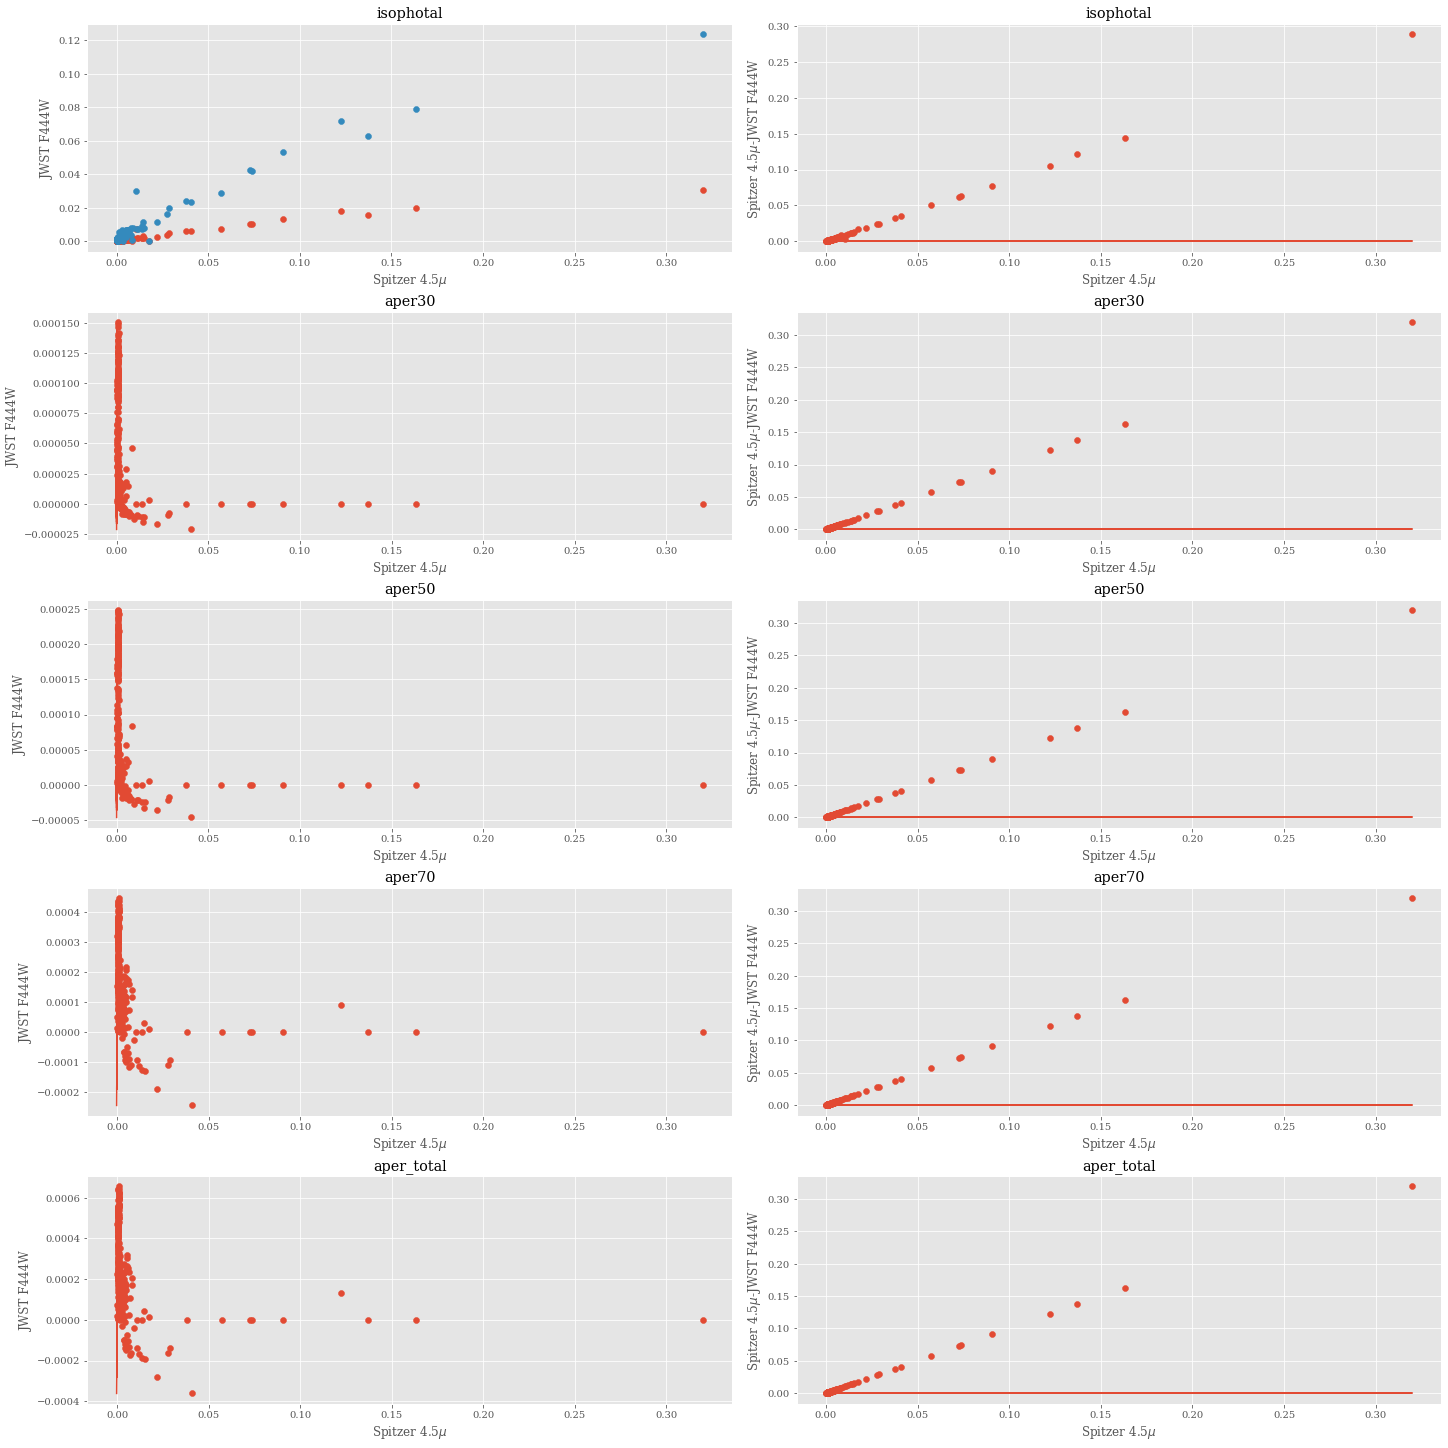

In [217]:
# plt.hist(jwst_spitz_cat.mag_IR2-jwst_spitz_cat[ap_type+'_'+meas_type+'_f444w'],bins=np.linspace(-20,10,15))
# idx_1, sep2d_1, _ = match_coordinates_sky(SkyCoord(["10:36:47.3 -58:38:10","10:36:52.3 -58:38:09"],unit=(u.hourangle, u.deg)), s2_sky, nthneighbor=1, storekdtree='kdtree_sky')
# print(sep2d_1)
# spit2m_cat.iloc[idx_1]
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'serif'
plt.rcParams['lines.color'] = 'brown'
plt.style.use('ggplot')
fig, ax = plt.subplots(5,2,figsize=(20,20),constrained_layout=True)


ax[0][0].scatter(jwst_spitz_cat.f_IR2,jwst_spitz_cat[ap_type+'_'+meas_type2+'_f444w'])
ax[0][0].scatter(jwst_spitz_cat.f_IR2,jwst_spitz_cat[ap_type+'_'+meas_type2+'_f444w']*4)
# ax[0][0].plot(jwst_spitz_cat[ap_type+'_'+meas_type2+'_f444w']*4,jwst_spitz_cat[ap_type+'_'+meas_type2+'_f444w']*4)
ax[0][1].scatter(jwst_spitz_cat.f_IR2,jwst_spitz_cat.f_IR2-jwst_spitz_cat[ap_type+'_'+meas_type2+'_f444w'])
# ax[0][1].plot(jwst_spitz_cat.f_IR2,0.8*jwst_spitz_cat.f_IR2)
ax[0][1].plot(jwst_spitz_cat.f_IR2,[0]*len(jwst_spitz_cat.f_IR2))
# ax[0][0].scatter(jwst_spitz_cat.mag_IR2,jwst_spitz_cat[ap_type+'_'+meas_type+'_f444w'])
# ax[0][0].plot(jwst_spitz_cat[ap_type+'_'+meas_type+'_f444w'],jwst_spitz_cat[ap_type+'_'+meas_type+'_f444w'])
# ax[0][1].scatter(jwst_spitz_cat.mag_IR2,jwst_spitz_cat.mag_IR2-jwst_spitz_cat[ap_type+'_'+meas_type+'_f444w'])
# ax[0][1].plot(jwst_spitz_cat.mag_IR2,jwst_spitz_cat.mag_IR2-jwst_spitz_cat.mag_IR2)

ax[0][0].set_ylabel('JWST F444W')
ax[0][0].set_xlabel('Spitzer 4.5$\mu$')

ax[0][1].set_ylabel('Spitzer 4.5$\mu$-JWST F444W')
ax[0][1].set_xlabel('Spitzer 4.5$\mu$')

ax[0][0].set_title(ap_type)
ax[0][1].set_title(ap_type)


ax[1][0].scatter(jwst_spitz_cat.f_IR2,jwst_spitz_cat[ap_type2+'_'+meas_type2+'_f444w'])
ax[1][0].plot(jwst_spitz_cat[ap_type2+'_'+meas_type2+'_f444w'],jwst_spitz_cat[ap_type2+'_'+meas_type2+'_f444w'])
ax[1][1].scatter(jwst_spitz_cat.f_IR2,jwst_spitz_cat.f_IR2-jwst_spitz_cat[ap_type2+'_'+meas_type2+'_f444w'])
ax[1][1].plot(jwst_spitz_cat.f_IR2,jwst_spitz_cat.f_IR2-jwst_spitz_cat.f_IR2)
# ax[1][0].scatter(jwst_spitz_cat.mag_IR2,jwst_spitz_cat[ap_type2+'_'+meas_type+'_f444w'])
# ax[1][0].plot(jwst_spitz_cat[ap_type2+'_'+meas_type+'_f444w'],jwst_spitz_cat[ap_type2+'_'+meas_type+'_f444w'])
# ax[1][1].scatter(jwst_spitz_cat.mag_IR2,jwst_spitz_cat.mag_IR2-jwst_spitz_cat[ap_type2+'_'+meas_type+'_f444w'])
# ax[1][1].plot(jwst_spitz_cat.mag_IR2,jwst_spitz_cat.mag_IR2-jwst_spitz_cat.mag_IR2)

ax[1][0].set_ylabel('JWST F444W')
ax[1][0].set_xlabel('Spitzer 4.5$\mu$')

ax[1][1].set_ylabel('Spitzer 4.5$\mu$-JWST F444W')
ax[1][1].set_xlabel('Spitzer 4.5$\mu$')

ax[1][0].set_title(ap_type2)
ax[1][1].set_title(ap_type2)


ax[2][0].scatter(jwst_spitz_cat.f_IR2,jwst_spitz_cat[ap_type3+'_'+meas_type2+'_f444w'])
ax[2][0].plot(jwst_spitz_cat[ap_type3+'_'+meas_type2+'_f444w'],jwst_spitz_cat[ap_type3+'_'+meas_type2+'_f444w'])
ax[2][1].scatter(jwst_spitz_cat.f_IR2,jwst_spitz_cat.f_IR2-jwst_spitz_cat[ap_type3+'_'+meas_type2+'_f444w'])
ax[2][1].plot(jwst_spitz_cat.f_IR2,jwst_spitz_cat.f_IR2-jwst_spitz_cat.f_IR2)
# ax[2][0].scatter(jwst_spitz_cat.mag_IR2,jwst_spitz_cat[ap_type3+'_'+meas_type+'_f444w'])
# ax[2][0].plot(jwst_spitz_cat[ap_type3+'_'+meas_type+'_f444w'],jwst_spitz_cat[ap_type3+'_'+meas_type+'_f444w'])
# ax[2][1].scatter(jwst_spitz_cat.mag_IR2,jwst_spitz_cat.mag_IR2-jwst_spitz_cat[ap_type3+'_'+meas_type+'_f444w'])
# ax[2][1].plot(jwst_spitz_cat.mag_IR2,jwst_spitz_cat.mag_IR2-jwst_spitz_cat.mag_IR2)

ax[2][0].set_ylabel('JWST F444W')
ax[2][0].set_xlabel('Spitzer 4.5$\mu$')

ax[2][1].set_ylabel('Spitzer 4.5$\mu$-JWST F444W')
ax[2][1].set_xlabel('Spitzer 4.5$\mu$')

ax[2][0].set_title(ap_type3)
ax[2][1].set_title(ap_type3)


ax[3][0].scatter(jwst_spitz_cat.f_IR2,jwst_spitz_cat[ap_type4+'_'+meas_type2+'_f444w'])
ax[3][0].plot(jwst_spitz_cat[ap_type4+'_'+meas_type2+'_f444w'],jwst_spitz_cat[ap_type4+'_'+meas_type2+'_f444w'])
ax[3][1].scatter(jwst_spitz_cat.f_IR2,jwst_spitz_cat.f_IR2-jwst_spitz_cat[ap_type4+'_'+meas_type2+'_f444w'])
ax[3][1].plot(jwst_spitz_cat.f_IR2,jwst_spitz_cat.f_IR2-jwst_spitz_cat.f_IR2)
# ax[3][0].scatter(jwst_spitz_cat.mag_IR2,jwst_spitz_cat[ap_type4+'_'+meas_type+'_f444w'])
# ax[3][0].plot(jwst_spitz_cat[ap_type4+'_'+meas_type+'_f444w'],jwst_spitz_cat[ap_type4+'_'+meas_type+'_f444w'])
# ax[3][1].scatter(jwst_spitz_cat.mag_IR2,jwst_spitz_cat.mag_IR2-jwst_spitz_cat[ap_type4+'_'+meas_type+'_f444w'])
# ax[3][1].plot(jwst_spitz_cat.mag_IR2,jwst_spitz_cat.mag_IR2-jwst_spitz_cat.mag_IR2)

ax[3][0].set_ylabel('JWST F444W')
ax[3][0].set_xlabel('Spitzer 4.5$\mu$')

ax[3][1].set_ylabel('Spitzer 4.5$\mu$-JWST F444W')
ax[3][1].set_xlabel('Spitzer 4.5$\mu$')

ax[3][0].set_title(ap_type4)
ax[3][1].set_title(ap_type4)



ax[4][0].scatter(jwst_spitz_cat.f_IR2,jwst_spitz_cat[ap_type5+'_'+meas_type2+'_f444w'])
ax[4][0].plot(jwst_spitz_cat[ap_type5+'_'+meas_type2+'_f444w'],jwst_spitz_cat[ap_type5+'_'+meas_type2+'_f444w'])
ax[4][1].scatter(jwst_spitz_cat.f_IR2,jwst_spitz_cat.f_IR2-jwst_spitz_cat[ap_type5+'_'+meas_type2+'_f444w'])
ax[4][1].plot(jwst_spitz_cat.f_IR2,jwst_spitz_cat.f_IR2-jwst_spitz_cat.f_IR2)
# ax[4][0].scatter(jwst_spitz_cat.mag_IR2,jwst_spitz_cat[ap_type5+'_'+meas_type+'_f444w'])
# ax[4][0].plot(jwst_spitz_cat[ap_type5+'_'+meas_type+'_f444w'],jwst_spitz_cat[ap_type5+'_'+meas_type+'_f444w'])
# ax[4][1].scatter(jwst_spitz_cat.mag_IR2,jwst_spitz_cat.mag_IR2-jwst_spitz_cat[ap_type5+'_'+meas_type+'_f444w'])
# ax[4][1].plot(jwst_spitz_cat.mag_IR2,jwst_spitz_cat.mag_IR2-jwst_spitz_cat.mag_IR2)

ax[4][0].set_ylabel('JWST F444W')
ax[4][0].set_xlabel('Spitzer 4.5$\mu$')

ax[4][1].set_ylabel('Spitzer 4.5$\mu$-JWST F444W')
ax[4][1].set_xlabel('Spitzer 4.5$\mu$')

ax[4][0].set_title(ap_type5)
ax[4][1].set_title(ap_type5)


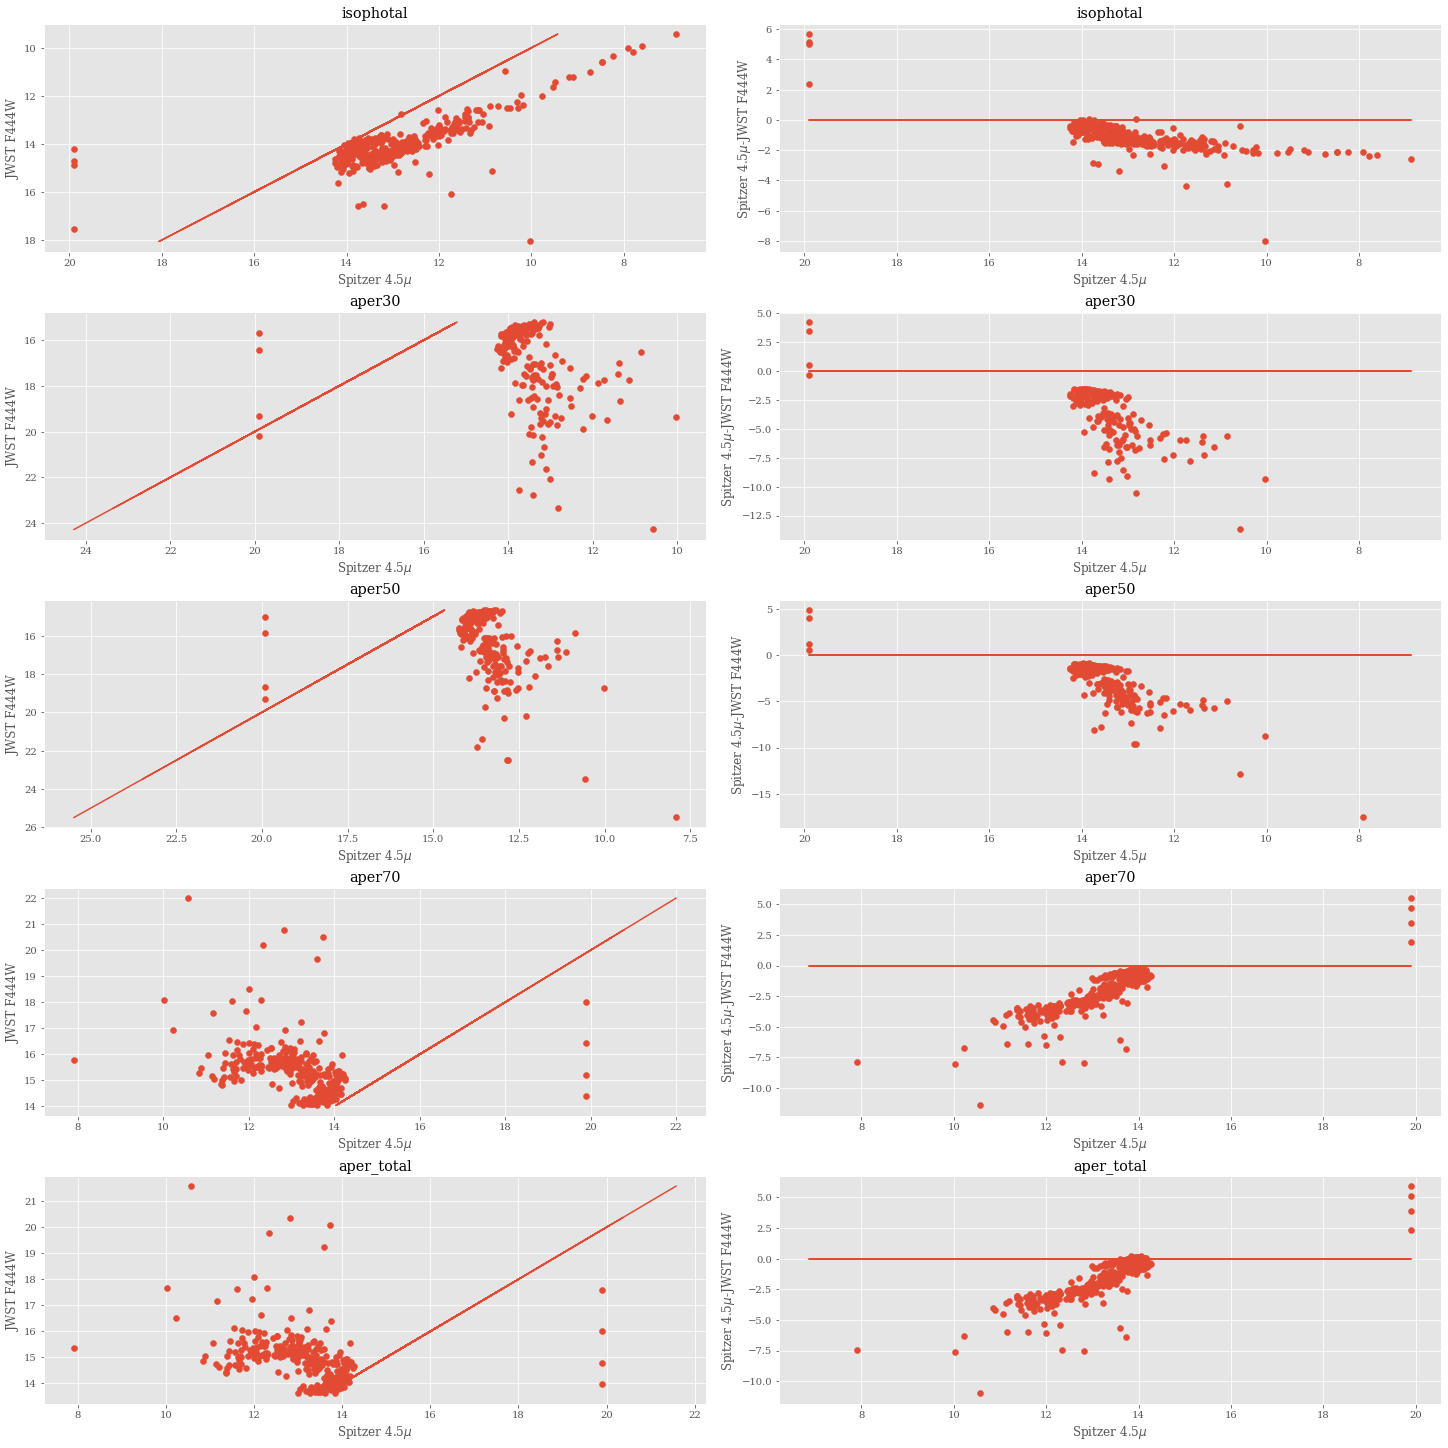

In [218]:
# plt.hist(jwst_spitz_cat.mag_IR2-jwst_spitz_cat[ap_type+'_'+meas_type+'_f444w'],bins=np.linspace(-20,10,15))
# idx_1, sep2d_1, _ = match_coordinates_sky(SkyCoord(["10:36:47.3 -58:38:10","10:36:52.3 -58:38:09"],unit=(u.hourangle, u.deg)), s2_sky, nthneighbor=1, storekdtree='kdtree_sky')
# print(sep2d_1)
# spit2m_cat.iloc[idx_1]
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'serif'
plt.rcParams['lines.color'] = 'brown'
plt.style.use('ggplot')
fig, ax = plt.subplots(5,2,figsize=(20,20),constrained_layout=True)

ax[0][0].invert_yaxis()
ax[1][0].invert_yaxis()
ax[2][0].invert_yaxis()
ax[0][0].invert_xaxis()
ax[1][0].invert_xaxis()
ax[2][0].invert_xaxis()
ax[0][1].invert_xaxis()
ax[1][1].invert_xaxis()
ax[2][1].invert_xaxis()
# ax[0][0].set_yscale('log')
# ax[0][0].set_xscale('log')
# axs[2][1].invert_yaxis()

# ax[0][0].scatter(jwst_spitz_cat.f_IR2,jwst_spitz_cat[ap_type+'_'+meas_type2+'_f444w'])
# ax[0][0].plot(jwst_spitz_cat[ap_type+'_'+meas_type2+'_f444w'],jwst_spitz_cat[ap_type+'_'+meas_type2+'_f444w'])
# ax[0][1].scatter(jwst_spitz_cat.f_IR2,jwst_spitz_cat.f_IR2-jwst_spitz_cat[ap_type+'_'+meas_type2+'_f444w'])
# ax[0][1].plot(jwst_spitz_cat.f_IR2,jwst_spitz_cat.f_IR2-jwst_spitz_cat.f_IR2)
ax[0][0].scatter(jwst_spitz_cat.mag_IR2,jwst_spitz_cat[ap_type+'_'+meas_type+'_f444w'])
ax[0][0].plot(jwst_spitz_cat[ap_type+'_'+meas_type+'_f444w'],jwst_spitz_cat[ap_type+'_'+meas_type+'_f444w'])
ax[0][1].scatter(jwst_spitz_cat.mag_IR2,jwst_spitz_cat.mag_IR2-jwst_spitz_cat[ap_type+'_'+meas_type+'_f444w'])
ax[0][1].plot(jwst_spitz_cat.mag_IR2,jwst_spitz_cat.mag_IR2-jwst_spitz_cat.mag_IR2)

ax[0][0].set_ylabel('JWST F444W')
ax[0][0].set_xlabel('Spitzer 4.5$\mu$')

ax[0][1].set_ylabel('Spitzer 4.5$\mu$-JWST F444W')
ax[0][1].set_xlabel('Spitzer 4.5$\mu$')

ax[0][0].set_title(ap_type)
ax[0][1].set_title(ap_type)


# ax[1][0].scatter(jwst_spitz_cat.f_IR2,jwst_spitz_cat[ap_type2+'_'+meas_type2+'_f444w'])
# ax[1][0].plot(jwst_spitz_cat[ap_type2+'_'+meas_type2+'_f444w'],jwst_spitz_cat[ap_type2+'_'+meas_type2+'_f444w'])
# ax[1][1].scatter(jwst_spitz_cat.f_IR2,jwst_spitz_cat.f_IR2-jwst_spitz_cat[ap_type2+'_'+meas_type2+'_f444w'])
# ax[1][1].plot(jwst_spitz_cat.f_IR2,jwst_spitz_cat.f_IR2-jwst_spitz_cat.f_IR2)
ax[1][0].scatter(jwst_spitz_cat.mag_IR2,jwst_spitz_cat[ap_type2+'_'+meas_type+'_f444w'])
ax[1][0].plot(jwst_spitz_cat[ap_type2+'_'+meas_type+'_f444w'],jwst_spitz_cat[ap_type2+'_'+meas_type+'_f444w'])
ax[1][1].scatter(jwst_spitz_cat.mag_IR2,jwst_spitz_cat.mag_IR2-jwst_spitz_cat[ap_type2+'_'+meas_type+'_f444w'])
ax[1][1].plot(jwst_spitz_cat.mag_IR2,jwst_spitz_cat.mag_IR2-jwst_spitz_cat.mag_IR2)

ax[1][0].set_ylabel('JWST F444W')
ax[1][0].set_xlabel('Spitzer 4.5$\mu$')

ax[1][1].set_ylabel('Spitzer 4.5$\mu$-JWST F444W')
ax[1][1].set_xlabel('Spitzer 4.5$\mu$')

ax[1][0].set_title(ap_type2)
ax[1][1].set_title(ap_type2)


# ax[2][0].scatter(jwst_spitz_cat.f_IR2,jwst_spitz_cat[ap_type3+'_'+meas_type2+'_f444w'])
# ax[2][0].plot(jwst_spitz_cat[ap_type3+'_'+meas_type2+'_f444w'],jwst_spitz_cat[ap_type3+'_'+meas_type2+'_f444w'])
# ax[2][1].scatter(jwst_spitz_cat.f_IR2,jwst_spitz_cat.f_IR2-jwst_spitz_cat[ap_type3+'_'+meas_type2+'_f444w'])
# ax[2][1].plot(jwst_spitz_cat.f_IR2,jwst_spitz_cat.f_IR2-jwst_spitz_cat.f_IR2)
ax[2][0].scatter(jwst_spitz_cat.mag_IR2,jwst_spitz_cat[ap_type3+'_'+meas_type+'_f444w'])
ax[2][0].plot(jwst_spitz_cat[ap_type3+'_'+meas_type+'_f444w'],jwst_spitz_cat[ap_type3+'_'+meas_type+'_f444w'])
ax[2][1].scatter(jwst_spitz_cat.mag_IR2,jwst_spitz_cat.mag_IR2-jwst_spitz_cat[ap_type3+'_'+meas_type+'_f444w'])
ax[2][1].plot(jwst_spitz_cat.mag_IR2,jwst_spitz_cat.mag_IR2-jwst_spitz_cat.mag_IR2)

ax[2][0].set_ylabel('JWST F444W')
ax[2][0].set_xlabel('Spitzer 4.5$\mu$')

ax[2][1].set_ylabel('Spitzer 4.5$\mu$-JWST F444W')
ax[2][1].set_xlabel('Spitzer 4.5$\mu$')

ax[2][0].set_title(ap_type3)
ax[2][1].set_title(ap_type3)


# ax[3][0].scatter(jwst_spitz_cat.f_IR2,jwst_spitz_cat[ap_type4+'_'+meas_type2+'_f444w'])
# ax[3][0].plot(jwst_spitz_cat[ap_type4+'_'+meas_type2+'_f444w'],jwst_spitz_cat[ap_type4+'_'+meas_type2+'_f444w'])
# ax[3][1].scatter(jwst_spitz_cat.f_IR2,jwst_spitz_cat.f_IR2-jwst_spitz_cat[ap_type4+'_'+meas_type2+'_f444w'])
# ax[3][1].plot(jwst_spitz_cat.f_IR2,jwst_spitz_cat.f_IR2-jwst_spitz_cat.f_IR2)
ax[3][0].scatter(jwst_spitz_cat.mag_IR2,jwst_spitz_cat[ap_type4+'_'+meas_type+'_f444w'])
ax[3][0].plot(jwst_spitz_cat[ap_type4+'_'+meas_type+'_f444w'],jwst_spitz_cat[ap_type4+'_'+meas_type+'_f444w'])
ax[3][1].scatter(jwst_spitz_cat.mag_IR2,jwst_spitz_cat.mag_IR2-jwst_spitz_cat[ap_type4+'_'+meas_type+'_f444w'])
ax[3][1].plot(jwst_spitz_cat.mag_IR2,jwst_spitz_cat.mag_IR2-jwst_spitz_cat.mag_IR2)

ax[3][0].set_ylabel('JWST F444W')
ax[3][0].set_xlabel('Spitzer 4.5$\mu$')

ax[3][1].set_ylabel('Spitzer 4.5$\mu$-JWST F444W')
ax[3][1].set_xlabel('Spitzer 4.5$\mu$')

ax[3][0].set_title(ap_type4)
ax[3][1].set_title(ap_type4)



# ax[4][0].scatter(jwst_spitz_cat.f_IR2,jwst_spitz_cat[ap_type5+'_'+meas_type2+'_f444w'])
# ax[4][0].plot(jwst_spitz_cat[ap_type5+'_'+meas_type2+'_f444w'],jwst_spitz_cat[ap_type5+'_'+meas_type2+'_f444w'])
# ax[4][1].scatter(jwst_spitz_cat.f_IR2,jwst_spitz_cat.f_IR2-jwst_spitz_cat[ap_type5+'_'+meas_type2+'_f444w'])
# ax[4][1].plot(jwst_spitz_cat.f_IR2,jwst_spitz_cat.f_IR2-jwst_spitz_cat.f_IR2)
ax[4][0].scatter(jwst_spitz_cat.mag_IR2,jwst_spitz_cat[ap_type5+'_'+meas_type+'_f444w'])
ax[4][0].plot(jwst_spitz_cat[ap_type5+'_'+meas_type+'_f444w'],jwst_spitz_cat[ap_type5+'_'+meas_type+'_f444w'])
ax[4][1].scatter(jwst_spitz_cat.mag_IR2,jwst_spitz_cat.mag_IR2-jwst_spitz_cat[ap_type5+'_'+meas_type+'_f444w'])
ax[4][1].plot(jwst_spitz_cat.mag_IR2,jwst_spitz_cat.mag_IR2-jwst_spitz_cat.mag_IR2)

ax[4][0].set_ylabel('JWST F444W')
ax[4][0].set_xlabel('Spitzer 4.5$\mu$')

ax[4][1].set_ylabel('Spitzer 4.5$\mu$-JWST F444W')
ax[4][1].set_xlabel('Spitzer 4.5$\mu$')

ax[4][0].set_title(ap_type5)
ax[4][1].set_title(ap_type5)


plt.savefig('mag comparison.png',dpi=300)

In [219]:
m0 = jwst_spitz_cat.isophotal_vegamag_f444w+2.5*np.log10(jwst_spitz_cat.isophotal_flux_f444w)
print(np.mean(m0))
# plt.hist(m0)
# plt.xlim(5.65818991661,5.658189916611)
# print(plt.xlim())

mc = m0-jwst_spitz_cat.isophotal_vegamag_f444w - 2.5*np.log10(jwst_spitz_cat.isophotal_flux_f444w*4)
print(np.mean(mc))

# plt.hist(mc)

5.658189916610582
-1.5051499783198978


[0. 1. 2.]


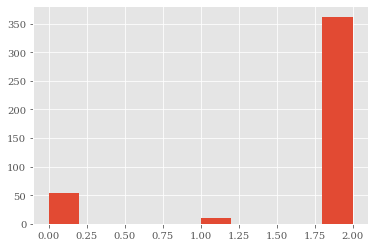

In [220]:
plt.hist(jwst_spitz_cat.Preds)

print(np.unique(jwst_spitz_cat.Preds))

# Locate all IR-Excess sources from Reiter 2022:


In [221]:
# IR-Excess sources found in Reiter 2022 (Diving off the Cosmic Cliffs)
reit = ["10:36:42.3 -58:38:04", "10:36:48.0 -58:38:19", "10:36:47.3 -58:38:10", "10:36:46.7 -58:38:05", "10:36:51.5 -58:37:54", "10:36:50.5 -58:37:52",\
    "10:36:51.4 -58:37:48", "10:36:53.8 -58:37:48", "10:36:51.5 -58:37:10", "10:36:54.2 -58:36:26", "10:36:54.4 -58:36:18", "10:36:54.0 -58:37:20",\
        "10:36:53.6 -58:35:20", "10:36:53.1 -58:37:37", "10:36:53.3 -58:37:54", "10:36:52.7 -58:38:05", "10:36:53.1 -58:37:08", "10:36:51.6 -58:36:58",\
        "10:36:52.3 -58:38:09", "10:36:53.9 -58:36:29", "10:37:01.5 -58:37:51", "10:37:02.1 -58:36:58", "10:36:53.9 -58:36:32"]# End of third row is the end of MHO-only sources
sky_1 = SkyCoord(reit,unit=(u.hourangle, u.deg))
ra_1 = sky_1.ra
dec_1 = sky_1.dec

reit_eg = ["10:36:53.7 -58:35:47", "10:36:59.5 -58:39:01", "10:37:07.2 -58:35:36", "10:36:55.2 -58:38:09"]
sky_1 = SkyCoord(reit_eg,unit=(u.hourangle, u.deg))
ra_eg = sky_1.ra
dec_eg = sky_1.dec


0.6538133891945108
[1.48263517e-05 2.66239963e-05 2.72821013e-05 1.89574271e-05
 9.25057923e-05 1.43459932e-04 3.76941190e-05 1.49479799e-04]
[159.20144011 159.20932988 159.22915862 159.21944689 159.20583871
 159.24694824 159.23111052 159.29439611]


(array([-1000.,     0.,  1000.,  2000.,  3000.,  4000.,  5000.,  6000.,
         7000.,  8000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

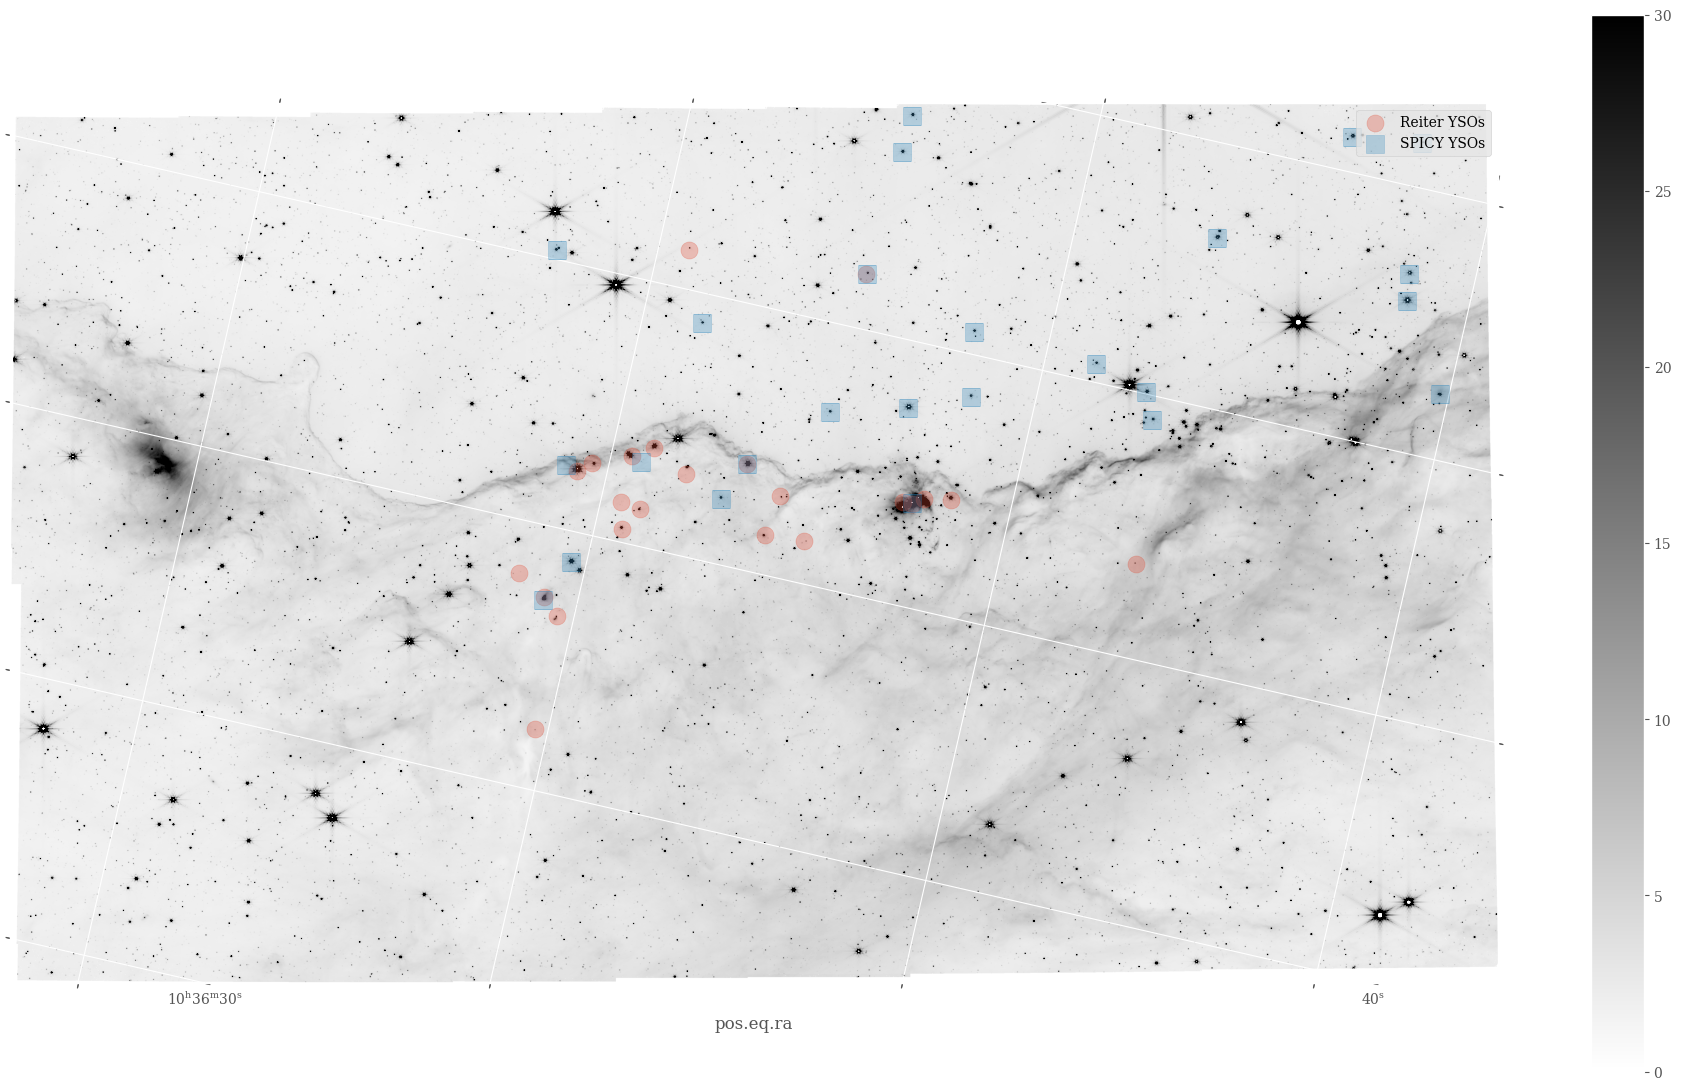

In [222]:
# Plot image
path2 = "../../ngc3324/NIRCAM_ALL/JWST/jw02731-o001_t017_nircam_"
filter = "clear-f444w"
image_file = path2+filter+'/jw02731-o001_t017_nircam_'+filter+'_i2d.fits'


h = fits.getheader(image_file)

f = fits.open(image_file)

wcs = WCS(f[1].header)

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(24,14),dpi=100)
ax = plt.subplot(projection=wcs)

plt.grid(color='white', ls='solid')
plt.imshow(f[1].data,cmap='gray_r',vmin=0,vmax=30,origin='lower') #vmax =1500 for f1800w
ymax, ymin = ax.get_ylim()
xmax, xmin = ax.get_xlim()
plt.colorbar()

ras, decs = wcs.wcs_pix2world(np.linspace(-500,15000,100), np.linspace(-500,16000,100), 1)
print(max(ras)-min(ras))

np8 = np.c_[np.array(jwst_spitz_cat.RA),np.array(jwst_spitz_cat.DEC),np.array(jwst_spitz_cat.mag_IR2),np.array(jwst_spitz_cat.Preds)]

yso = np.where(np8[:,-1]==0)[0]
egs = np.where(np8[:,-1]==1)[0]
sta = np.where(np8[:,-1]==2)[0]
n = np.array([0,1,2,3,4,30,50, 300])
print(np.array(jwst_cat['size'])[n])
print(np.array(jwst_cat['RA'])[n])
plt.scatter(ra_1,dec_1, marker='o', s=150, alpha=0.3,transform=ax.get_transform('fk5'),label='Reiter YSOs')
# plt.scatter(ra_eg,dec_eg, marker='o', c='gold',s=150, alpha=0.3,transform=ax.get_transform('fk5'),label='Reiter EGs')
# plt.plot([np.array(jwst_spitz_cat.RA)[n],np.array(jwst_spitz_cat.RA)[n]+np.array(jwst_spitz_cat['size'])[n]],[np.array(jwst_spitz_cat.DEC)[n],np.array(jwst_spitz_cat.DEC)[n]], c='r',transform=ax.get_transform('fk5'),label='Size')
plt.scatter(jwst_spitz_spicy_cat.dropna(subset='SPICY').RA.values,jwst_spitz_spicy_cat.dropna(subset='SPICY').DEC.values, marker='s', s=150, alpha=0.3,transform=ax.get_transform('fk5'),label='SPICY YSOs')
# ax.scatter(np8[yso,0],np8[yso,1], marker='*', c='b',s=60, alpha=0.8, transform=ax.get_transform('fk5'), label = "SPY-finder YSOs")
# ax.scatter(np8[egs,0],np8[egs,1], marker='*', c='y',s=60, alpha=0.8, transform=ax.get_transform('fk5'), label = "SPY-finder EGs")
# ax.scatter(np8[sta,0],np8[sta,1], marker='*', c='g',s=60, alpha=0.8, transform=ax.get_transform('fk5'), label = "SPY-finder Stars")
ax.set_ylim(ymax, ymin)
ax.set_xlim(xmax, xmin)
plt.legend(loc=1)
plt.xticks()

# plt.savefig(f"../../ngc3324/CC_w_Reiter_RF_Label_{filter}.png",dpi=100)


In [223]:
len(np.unique(jwst_spitz_spicy_cat.SPICY.values))

26

In [224]:
jwst_spitz_spicy_cat.to_csv('../Phase_4__2MASS_UpperLim_Classification/Scripts/CC_Webb_NIRCam_MIRI_Spitz_2m_w_SPICY_Preds_Dec162022.csv')

In [225]:
jwst_spitz_spicy_cat[bands].head(-1)

,isophotal_vegamag_f200w,isophotal_vegamag_err_f200w,isophotal_vegamag_f090w,isophotal_vegamag_err_f090w,isophotal_vegamag_f187n,isophotal_vegamag_err_f187n,isophotal_vegamag_f335m,isophotal_vegamag_err_f335m,isophotal_vegamag_f444w,isophotal_vegamag_err_f444w,isophotal_vegamag_f444w-f470n,isophotal_vegamag_err_f444w-f470n,isophotal_vegamag_f770w,isophotal_vegamag_err_f770w,isophotal_vegamag_f1130w,isophotal_vegamag_err_f1130w,isophotal_vegamag_f1280w,isophotal_vegamag_err_f1280w,isophotal_vegamag_f1800w,isophotal_vegamag_err_f1800w
0,15.462969,0.000972,NaN,NaN,14.021662,0.002170,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,16.095161,0.001462,19.883675,0.003923,NaN,NaN,15.336500,0.002554,14.713185,0.000934,13.682374,0.001650,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,11.702746,0.000269,12.347944,0.000302,11.979456,0.000202,10.502940,0.000642,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,14.301755,0.001485,14.413617,0.001918,14.272268,0.001512,14.114955,0.002430,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,13.169119,0.000193,17.310833,0.002284,12.884173,0.000389,NaN,NaN,12.594159,0.000266,11.493514,0.000929,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,NaN,NaN,16.827093,0.001967,NaN,NaN,NaN,NaN,13.734207,0.000465,13.904423,0.000869,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
422,15.083637,0.000444,16.902101,0.002905,15.270985,0.001910,14.126329,0.001077,13.794788,0.001489,13.653016,0.001596,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
423,13.903761,0.000242,14.798483,0.000288,14.010373,0.000601,14.125227,0.000739,14.097298,0.000603,12.847836,0.000713,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
424,NaN,NaN,NaN,NaN,13.045309,0.000281,12.903984,0.000257,NaN,NaN,NaN,NaN,11.500409,0.000658,NaN,NaN,12.529939,0.000383,NaN,NaN


In [226]:
jwst_spitz_spicy_cat.iloc[31]

RA                             159.191397
DEC                            -58.560859
size                             0.000193
isophotal_vegamag_f200w         15.168283
isophotal_vegamag_err_f200w       0.00061
                                  ...    
alpha                           -10.63296
Preds                                 2.0
SPICY                                 NaN
SPICY_Class                           NaN
SPICY_Class_0/1                         1
Name: 31, Length: 224, dtype: object

# SPICY

In [40]:
# print('J'+np.array(jwst_spitz_cat.RA)+np.array(jwst_spitz_cat.DEC))
def deg_to_hrminsec(deg):
    deg = deg*u.deg
    h = deg.to(u.hourangle)/u.hourangle
    m = (h%1)*60
    s = (m%1)*60
    return str(int(h))+"{:02d}".format(int(m))+"{:04.1f}".format(s)
def deghr_to_hrminsec(deg):
    h = deg
    # print(Angle(deg,u.hourangle).hms)
    m = 60-(h%1)*60
    s = (m%1)*60
    return str(int(h))+"{:02d}".format(int(m))+"{:02d}".format(int(s))

jwst_num = []


for i, r in enumerate(np.array(jwst_spitz_cat.RA)):
    jwst_num.append('J'+deg_to_hrminsec(r)+deghr_to_hrminsec(np.array(jwst_spitz_cat.DEC)[i]))

# Distribution of nan values and objects classified as YSOs/Stars

array([[<AxesSubplot:title={'center':'Preds'}>]], dtype=object)

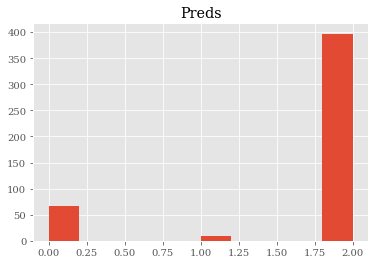

In [31]:
jwst_spitz_cat.hist('Preds')

In [32]:
np.count_nonzero(~np.isnan(jwst_spitz_cat[ap_type+'_'+meas_type+'_f444w']))

339

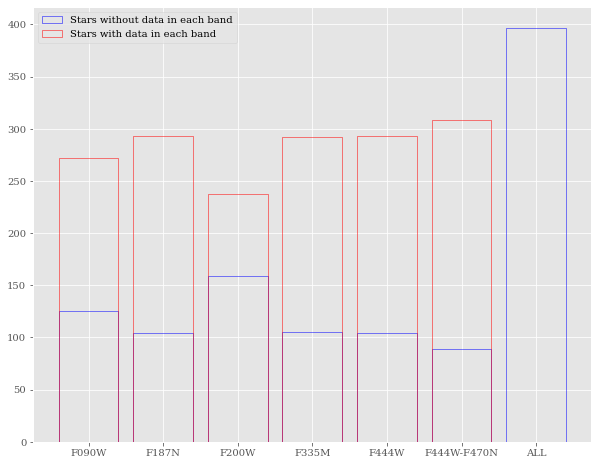

In [33]:
plt.subplots(figsize=(10,8))

plt.bar(['F090W','F187N','F200W','F335M','F444W','F444W-F470N', 'ALL'],[np.count_nonzero(np.isnan(jwst_spitz_cat.iloc[sta][ap_type+'_'+meas_type+'_f090w'])),\
    np.count_nonzero(np.isnan(jwst_spitz_cat.iloc[sta][ap_type+'_'+meas_type+'_f187n'])),np.count_nonzero(np.isnan(jwst_spitz_cat.iloc[sta][ap_type+'_'+meas_type+'_f200w'])),\
        np.count_nonzero(np.isnan(jwst_spitz_cat.iloc[sta][ap_type+'_'+meas_type+'_f335m'])),np.count_nonzero(np.isnan(jwst_spitz_cat.iloc[sta][ap_type+'_'+meas_type+'_f444w'])),\
            np.count_nonzero(np.isnan(jwst_spitz_cat.iloc[sta][ap_type+'_'+meas_type+'_f444w-f470n'])),jwst_spitz_cat.iloc[sta].shape[0] - jwst_spitz_cat.iloc[sta].dropna().shape[0]],fill=False,edgecolor='b',label='Stars without data in each band')

plt.bar(['F090W','F187N','F200W','F335M','F444W','F444W-F470N', 'ALL'],[np.count_nonzero(~np.isnan(jwst_spitz_cat.iloc[sta][ap_type+'_'+meas_type+'_f090w'])),\
    np.count_nonzero(~np.isnan(jwst_spitz_cat.iloc[sta][ap_type+'_'+meas_type+'_f187n'])),np.count_nonzero(~np.isnan(jwst_spitz_cat.iloc[sta][ap_type+'_'+meas_type+'_f200w'])),\
        np.count_nonzero(~np.isnan(jwst_spitz_cat.iloc[sta][ap_type+'_'+meas_type+'_f335m'])),np.count_nonzero(~np.isnan(jwst_spitz_cat.iloc[sta][ap_type+'_'+meas_type+'_f444w'])),\
            np.count_nonzero(~np.isnan(jwst_spitz_cat.iloc[sta][ap_type+'_'+meas_type+'_f444w-f470n'])),jwst_spitz_cat.iloc[sta].dropna().shape[0]],fill=False,edgecolor='r',label='Stars with data in each band')

# plt.plot(['F090W','F187N','F200W','F335M','F444W','F444W-F470N', 'ALL'],[np.count_nonzero(~np.isnan(jwst_spitz_cat.iloc[sta][ap_type+'_'+meas_type+'_f090w'])),\
#     np.count_nonzero(~np.isnan(jwst_spitz_cat.iloc[sta][ap_type+'_'+meas_type+'_f187n'])),np.count_nonzero(~np.isnan(jwst_spitz_cat.iloc[sta][ap_type+'_'+meas_type+'_f200w'])),\
#         np.count_nonzero(~np.isnan(jwst_spitz_cat.iloc[sta][ap_type+'_'+meas_type+'_f335m'])),np.count_nonzero(~np.isnan(jwst_spitz_cat.iloc[sta][ap_type+'_'+meas_type+'_f444w'])),\
#             np.count_nonzero(~np.isnan(jwst_spitz_cat.iloc[sta][ap_type+'_'+meas_type+'_f444w-f470n'])),jwst_spitz_cat.iloc[sta].dropna().shape[0]],color='r')
plt.legend()

67


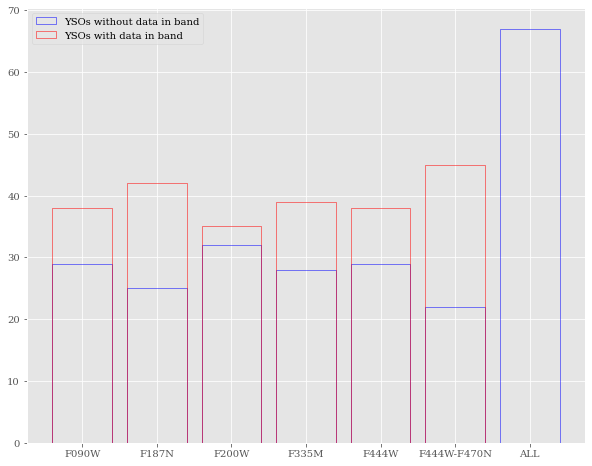

In [34]:
plt.subplots(figsize=(10,8))

plt.bar(['F090W','F187N','F200W','F335M','F444W','F444W-F470N', 'ALL'],[np.count_nonzero(np.isnan(jwst_spitz_cat.loc[yso][ap_type+'_'+meas_type+'_f090w'])),\
    np.count_nonzero(np.isnan(jwst_spitz_cat.iloc[yso][ap_type+'_'+meas_type+'_f187n'])),np.count_nonzero(np.isnan(jwst_spitz_cat.iloc[yso][ap_type+'_'+meas_type+'_f200w'])),\
        np.count_nonzero(np.isnan(jwst_spitz_cat.iloc[yso][ap_type+'_'+meas_type+'_f335m'])),np.count_nonzero(np.isnan(jwst_spitz_cat.iloc[yso][ap_type+'_'+meas_type+'_f444w'])),\
            np.count_nonzero(np.isnan(jwst_spitz_cat.iloc[yso][ap_type+'_'+meas_type+'_f444w-f470n'])),jwst_spitz_cat.iloc[yso].shape[0] - jwst_spitz_cat.iloc[yso].dropna().shape[0]],fill=False,edgecolor='b',label='YSOs without data in band')


plt.bar(['F090W','F187N','F200W','F335M','F444W','F444W-F470N', "ALL"],[np.count_nonzero(~np.isnan(jwst_spitz_cat.loc[yso][ap_type+'_'+meas_type+'_f090w'])),\
    np.count_nonzero(~np.isnan(jwst_spitz_cat.iloc[yso][ap_type+'_'+meas_type+'_f187n'])),np.count_nonzero(~np.isnan(jwst_spitz_cat.iloc[yso][ap_type+'_'+meas_type+'_f200w'])),\
        np.count_nonzero(~np.isnan(jwst_spitz_cat.iloc[yso][ap_type+'_'+meas_type+'_f335m'])),np.count_nonzero(~np.isnan(jwst_spitz_cat.iloc[yso][ap_type+'_'+meas_type+'_f444w'])),\
            np.count_nonzero(~np.isnan(jwst_spitz_cat.iloc[yso][ap_type+'_'+meas_type+'_f444w-f470n'])),jwst_spitz_cat.iloc[yso].dropna().shape[0]],fill=False,edgecolor='r',label='YSOs with data in band')

print(jwst_spitz_cat.iloc[yso].shape[0])

plt.legend()

In [40]:
# # plt.subplots(figsize=(12,12))

# bands = [idx for idx in jwst_spitz_cat.columns if (idx[:3] == 'iso' and idx[-9:-6] != 'err')] 
# print(bands)
# pd.plotting.scatter_matrix(jwst_spitz_cat.iloc[yso][bands],figsize=(12,12),color='turquoise')
# pd.plotting.scatter_matrix(jwst_spitz_cat.iloc[sta][bands],figsize=(12,12),color='r')

In [41]:
bands

['isophotal_vegamag_f090w',
 'isophotal_flux_f090w',
 'isophotal_vegamag_f187n',
 'isophotal_flux_f187n',
 'isophotal_vegamag_f200w',
 'isophotal_flux_f200w',
 'isophotal_vegamag_f335m',
 'isophotal_flux_f335m',
 'isophotal_vegamag_f444w',
 'isophotal_flux_f444w',
 'isophotal_vegamag_f444w-f470n',
 'isophotal_vegamag_err_f444w-f470n',
 'isophotal_flux_f444w-f470n',
 'isophotal_flux_err_f444w-f470n',
 'isophotal_vegamag_f770w',
 'isophotal_flux_f770w',
 'isophotal_vegamag_f1130w',
 'isophotal_vegamag_err_f1130w',
 'isophotal_flux_f1130w',
 'isophotal_flux_err_f1130w',
 'isophotal_vegamag_f1280w',
 'isophotal_vegamag_err_f1280w',
 'isophotal_flux_f1280w',
 'isophotal_flux_err_f1280w',
 'isophotal_vegamag_f1800w',
 'isophotal_vegamag_err_f1800w',
 'isophotal_flux_f1800w',
 'isophotal_flux_err_f1800w']

(array([0.14141414, 0.36767677, 0.08484848, 0.31111111, 0.02828283,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ]),
 array([10.        , 11.07142857, 12.14285714, 13.21428571, 14.28571429,
        15.35714286, 16.42857143, 17.5       , 18.57142857, 19.64285714,
        20.71428571, 21.78571429, 22.85714286, 23.92857143, 25.        ]),
 [<matplotlib.patches.Polygon at 0x16b41f040>])

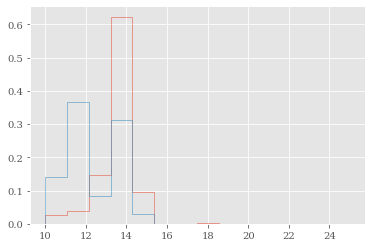

In [42]:
band = 'f444w'
plt.hist(jwst_spitz_cat.iloc[sta][ap_type+'_'+meas_type+'_'+band],bins=np.linspace(10,25,15),label='stars',density=True,histtype='step')
plt.hist(jwst_spitz_cat.iloc[yso][ap_type+'_'+meas_type+'_'+band],bins=np.linspace(10,25,15),label='ysos',density=True,histtype='step')

In [47]:
from sklearn.manifold import TSNE
# print(bands)

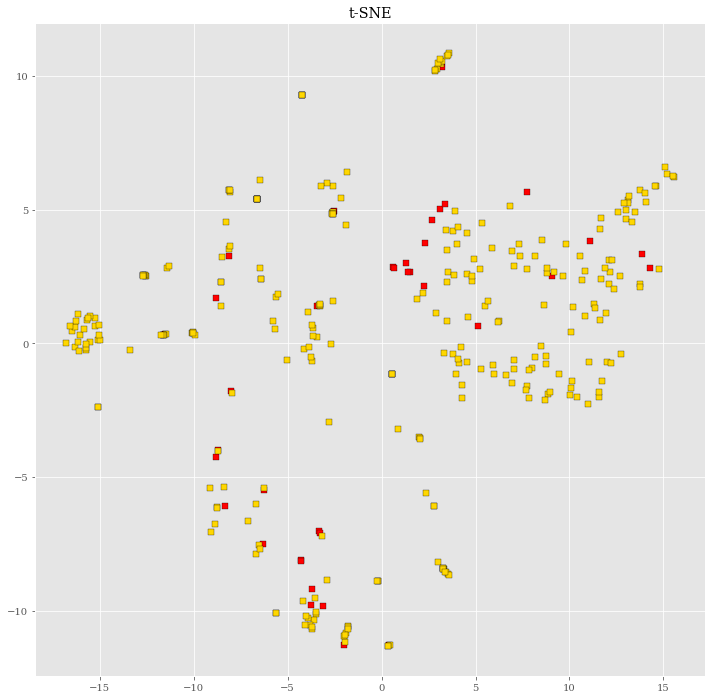

In [48]:
tsne = TSNE(
        n_components=2,
        init="random",
        random_state=11,
        perplexity=30,
        learning_rate="auto",
        n_iter=300)

droppna = jwst_spitz_spicy_cat.fillna(0)
Y = tsne.fit_transform(droppna[bands])

lw = 0.3

plt.subplots(figsize=(12,12))

plt.rcParams["scatter.edgecolors"]  = 'k'
plt.rcParams["font.family"] = "times"
plt.title("t-SNE")

plt.scatter(Y[np.where(droppna.Preds==0)[0], 0], Y[np.where(droppna.Preds==0)[0], 1], c="red",marker='s',linewidths=lw,label='Stars')
plt.scatter(Y[np.where(droppna.Preds==2)[0], 0], Y[np.where(droppna.Preds==2)[0], 1], c="gold",marker='s',linewidths=lw,label='EG')
    

In [ ]:
cols = np.r_[bands, ['Preds']]
fillna = jwst_spitz_cat[cols]
for band in bands[:6]:
    print(band)
    min = np.nanmax(jwst_spitz_cat[[band]])
    print(min+5)
    fillna[band].fillna(min+5,inplace=True)


fillna.head()

isophotal_vegamag_f090w
30.56144249722696
isophotal_vegamag_f187n
26.240837226461764
isophotal_vegamag_f200w
23.13808652440421
isophotal_vegamag_f335m
22.173117395850717
isophotal_vegamag_f444w
22.672818919714175
isophotal_vegamag_f444w-f470n
22.842365482839682


/var/folders/qy/7yz8bmv96hx8rndql_rfdz_80000gn/T/ipykernel_24154/601905150.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fillna[band].fillna(min+5,inplace=True)
/var/folders/qy/7yz8bmv96hx8rndql_rfdz_80000gn/T/ipykernel_24154/601905150.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fillna[band].fillna(min+5,inplace=True)
/var/folders/qy/7yz8bmv96hx8rndql_rfdz_80000gn/T/ipykernel_24154/601905150.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

,isophotal_vegamag_f090w,isophotal_vegamag_f187n,isophotal_vegamag_f200w,isophotal_vegamag_f335m,isophotal_vegamag_f444w,isophotal_vegamag_f444w-f470n,mag_J,mag_H,mag_Ks,mag_IR1,mag_IR2,mag_IR3,mag_IR4,Preds
0,30.561442,26.240837,11.416486,10.133513,8.722870,7.618336,12.242,10.990,10.103,9.117,8.505,8.040,6.691,0.0
1,10.044549,8.912283,9.042986,8.882913,8.725649,22.842365,11.740,11.466,11.413,11.400,11.430,11.342,11.373,2.0
2,30.561442,26.240837,10.271229,9.307425,8.999677,22.842365,10.772,9.712,8.685,7.416,6.873,6.399,5.622,0.0
3,10.788224,8.925118,9.253842,9.154792,9.411055,8.735966,8.283,7.807,7.665,7.651,7.792,7.715,7.602,0.0
4,30.561442,26.240837,10.835843,9.847233,9.588167,8.755222,11.693,10.819,9.871,8.670,7.916,7.082,5.858,0.0
